In [499]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import make_column_transformer


from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Activation, Flatten, LSTM

from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns


In [142]:
ls ../data

country_code_lookup.csv  yemen_batch0.csv  yemen_batch0.pkl  yemen_batch1.pkl
event_code_lookup.csv    yemen_batch0.pk   yemen_batch1.csv


In [221]:
yemen_df0 = pd.read_csv('../data/yemen_batch0.csv', index_col=0)
yemen_df0.head(2)

,Actor1Name,Actor2Name,QuadClass,GoldsteinScale,NumArticles,AvgTone,IsHumanitarianCrisis,sum,count,mean
SQLDATE,,,,,,,,,,
2014-02-19,ADEN,BRITAIN,3,-6.5,3,-2.103250,False,0,9,0.0
2014-02-19,YEMENI,LIBYA,1,1.9,2,-6.102747,False,0,9,0.0


# Generator for Batch Processing Test

In [316]:
def load_data(filename, idx):
    df = pd.read_csv('../data/{}{}.csv'.format(filename, idx), index_col=0)
    features = ['QuadClass','GoldsteinScale','NumArticles','AvgTone']
    X_train = df[features]
    y_train = df['mean']
    return X_train, y_train

In [300]:
def batch_generator(filename,n):
    idx = 0
    while idx<n:
        yield load_data(filename=filename, idx=idx)
        idx+=1

In [306]:
filename = 'yemen_batch'
gen = batch_generator(filename, 2)

In [229]:
# next(gen)

# One Hot Encoding for Categorical Variables

In [232]:
features_ohe = yemen_df0.Actor1Name.value_counts()[yemen_df0.Actor1Name.value_counts().values > 50].keys()

In [241]:
yemen_df0_sub = yemen_df0[yemen_df0.Actor1Name.isin(features_ohe)]
yemen_df0_sub.head()

,Actor1Name,Actor2Name,QuadClass,GoldsteinScale,NumArticles,AvgTone,IsHumanitarianCrisis,sum,count,mean
SQLDATE,,,,,,,,,,
2014-02-19,ADEN,BRITAIN,3,-6.5,3,-2.103250,False,0,9,0.0
2014-02-19,YEMENI,LIBYA,1,1.9,2,-6.102747,False,0,9,0.0
2014-02-19,LIBYA,YEMENI,1,2.8,2,-6.102747,False,0,9,0.0
2014-02-19,YEMENI,LIBYA,1,1.9,1,-6.243603,False,0,9,0.0
2014-02-19,LIBYA,YEMENI,1,2.8,1,-6.243603,False,0,9,0.0


In [245]:
yemen_df0_sub.fillna('None', inplace=True)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [264]:
col = ['Actor1Name', 'Actor2Name', 'IsHumanitarianCrisis']
column_trans = make_column_transformer(
                        (OneHotEncoder(handle_unknown = 'ignore'),  col),
                        remainder='passthrough')
column_trans.fit_transform(yemen_df0_sub)

<12274x498 sparse matrix of type '<class 'numpy.float64'>'
	with 119264 stored elements in Compressed Sparse Row format>

In [254]:
onehotencodeer = OneHotEncoder(handle_unknown='ignore')
onehotencodeer.fit_transform(yemen_df0_sub)

<12274x5255 sparse matrix of type '<class 'numpy.float64'>'
	with 122740 stored elements in Compressed Sparse Row format>

In [262]:
len(yemen_df0['mean'])

18435

In [236]:
# yemen_df0.Actor2Name.value_counts()[yemen_df0.Actor2Name.value_counts().values > 50].keys()

# NN model with Batch Processing

In [320]:
model = Sequential()
model.add(Dense(units=1, input_dim=4))
model.compile(loss='mean_squared_error', optimizer='sgd')

In [321]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [360]:
features = ['QuadClass','GoldsteinScale','NumArticles','AvgTone']
X_train = yemen_df0[features]
y_train = yemen_df0['mean']

In [324]:
X_train.head(2)

,QuadClass,GoldsteinScale,NumArticles,AvgTone
SQLDATE,,,,
2014-02-19,3,-6.5,3,-2.103250
2014-02-19,1,1.9,2,-6.102747


In [291]:
col = ['Actor1Name', 'Actor2Name']
X_train.fillna('None', inplace=True)
column_trans = make_column_transformer(
                        (OneHotEncoder(handle_unknown = 'ignore'),  col))
X_train_ohe = column_trans.fit_transform(X_train)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [292]:
model.fit(X_train_ohe, y_train)

18435/18435 [==============================] - 1s 45us/sample - loss: 0.0057


In [322]:
model.fit_generator(batch_generator(filename, 2), steps_per_epoch=2)

2/2 [==============================] - 0s 131ms/step - loss: 51.5327


In [313]:
len(column_trans.get_feature_names())

1177

In [325]:
model.predict(X_train)

array([[ 2.16504  ],
       [-1.0053207],
       [-1.713297 ],
       ...,
       [-9.454945 ],
       [ 2.8743365],
       [-7.5633974]], dtype=float32)

In [337]:
yemen_df0.head(2)

,Actor1Name,Actor2Name,QuadClass,GoldsteinScale,NumArticles,AvgTone,IsHumanitarianCrisis,sum,count,mean
SQLDATE,,,,,,,,,,
2014-02-19,ADEN,BRITAIN,3,-6.5,3,-2.103250,False,0,9,0.0
2014-02-19,YEMENI,LIBYA,1,1.9,2,-6.102747,False,0,9,0.0


In [362]:
X_train.tail(5)

,QuadClass,GoldsteinScale,NumArticles,AvgTone
SQLDATE,,,,
2015-02-28,4,-5.0,4,0.397812
2015-02-28,1,7.0,4,-2.431611
2015-02-28,1,3.5,10,2.054795
2015-02-28,4,-10.0,10,-8.490566
2015-02-28,1,7.0,2,0.826446


# Label Encoding For Categorical Variables

In [363]:
label_col = ['QuadClass']
label_encoder = LabelEncoder()

X_train[label_col] = label_encoder.fit_transform(X_train[label_col])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [364]:
X_train.tail(5)

,QuadClass,GoldsteinScale,NumArticles,AvgTone
SQLDATE,,,,
2015-02-28,3,-5.0,4,0.397812
2015-02-28,0,7.0,4,-2.431611
2015-02-28,0,3.5,10,2.054795
2015-02-28,3,-10.0,10,-8.490566
2015-02-28,0,7.0,2,0.826446


# Standardizing Data

In [366]:
stdscaler = StandardScaler()
X_train_scaled = stdscaler.fit_transform(X_train)
X_train_scaled

array([[ 0.715327  , -1.09962278, -0.57030264,  0.38771791],
       [-0.87462396,  0.4354165 , -0.74302367, -0.90855672],
       [-0.87462396,  0.59988499, -0.74302367, -0.90855672],
       ...,
       [-0.87462396,  0.72780493,  0.63874458,  1.7353797 ],
       [ 1.51030248, -1.73922247,  0.63874458, -1.68247161],
       [-0.87462396,  1.36740463, -0.74302367,  1.3372604 ]])

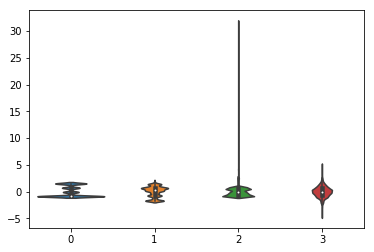

In [376]:
sns.violinplot( data=pd.DataFrame(X_train_scaled));

# Time-series Forecasting

In [384]:
X_train.shift(6).head(7)

,QuadClass,GoldsteinScale,NumArticles,AvgTone
SQLDATE,,,,
2014-02-19,NaN,NaN,NaN,NaN
2014-02-19,NaN,NaN,NaN,NaN
2014-02-19,NaN,NaN,NaN,NaN
2014-02-19,NaN,NaN,NaN,NaN
2014-02-19,NaN,NaN,NaN,NaN
2014-02-19,NaN,NaN,NaN,NaN
2014-02-19,2.0,-6.5,3.0,-2.10325


In [392]:
yemen_df0['mean'].rolling(2).mean().tail(25)

SQLDATE
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
2015-02-28    0.030075
Name: mean, dtype: float64

In [395]:
X_train.tail(10)

,QuadClass,GoldsteinScale,NumArticles,AvgTone
SQLDATE,,,,
2015-02-28,3,-9.5,2,-12.380952
2015-02-28,3,-5.0,10,-3.375527
2015-02-28,0,4.0,10,-0.197239
2015-02-28,0,0.0,10,-1.933702
2015-02-28,0,7.0,2,1.063830
2015-02-28,3,-5.0,4,0.397812
2015-02-28,0,7.0,4,-2.431611
2015-02-28,0,3.5,10,2.054795
2015-02-28,3,-10.0,10,-8.490566


In [396]:
X_train.shift(2).tail(7)

,QuadClass,GoldsteinScale,NumArticles,AvgTone
SQLDATE,,,,
2015-02-28,3.0,-5.0,10.0,-3.375527
2015-02-28,0.0,4.0,10.0,-0.197239
2015-02-28,0.0,0.0,10.0,-1.933702
2015-02-28,0.0,7.0,2.0,1.063830
2015-02-28,3.0,-5.0,4.0,0.397812
2015-02-28,0.0,7.0,4.0,-2.431611
2015-02-28,0.0,3.5,10.0,2.054795


In [403]:
y_train.describe()

count    18435.000000
mean         0.040900
std          0.048333
min          0.000000
25%          0.028506
50%          0.037514
75%          0.046339
max          1.000000
Name: mean, dtype: float64

In [404]:
print('Min date from train set: %s' % yemen_df0.index.min())
print('Max date from train set: %s' % yemen_df0.index.max())

Min date from train set: 2014-02-19
Max date from train set: 2015-02-28


In [423]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('{}(t-{})'.format(col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('{}(t)'.format(col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('{}(t+{})'.format(col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [424]:
window = 2
for i in range(window, 0, -1):
    print(i)

col = 'col'
'{}(t-{})'.format(col, i)

2
1


'col(t-1)'

In [419]:
X_train.shift(-1).tail()

,QuadClass,GoldsteinScale,NumArticles,AvgTone
SQLDATE,,,,
2015-02-28,0.0,7.0,4.0,-2.431611
2015-02-28,0.0,3.5,10.0,2.054795
2015-02-28,3.0,-10.0,10.0,-8.490566
2015-02-28,0.0,7.0,2.0,0.826446
2015-02-28,NaN,NaN,NaN,NaN


In [422]:
pd.concat([X_train, X_train], axis=1).head()

,QuadClass,GoldsteinScale,NumArticles,AvgTone,QuadClass,GoldsteinScale,NumArticles,AvgTone
SQLDATE,,,,,,,,
2014-02-19,2,-6.5,3,-2.103250,2,-6.5,3,-2.103250
2014-02-19,0,1.9,2,-6.102747,0,1.9,2,-6.102747
2014-02-19,0,2.8,2,-6.102747,0,2.8,2,-6.102747
2014-02-19,0,1.9,1,-6.243603,0,1.9,1,-6.243603
2014-02-19,0,8.0,10,-2.422907,0,8.0,10,-2.422907


In [428]:
X_train_ts = series_to_supervised(X_train, window=1, lag=1, dropnan=False)
X_train_ts

,QuadClass(t-1),GoldsteinScale(t-1),NumArticles(t-1),AvgTone(t-1),QuadClass(t),GoldsteinScale(t),NumArticles(t),AvgTone(t),QuadClass(t+1),GoldsteinScale(t+1),NumArticles(t+1),AvgTone(t+1)
SQLDATE,,,,,,,,,,,,
2014-02-19,NaN,NaN,NaN,NaN,2,-6.5,3,-2.103250,0.0,1.9,2.0,-6.102747
2014-02-19,2.0,-6.5,3.0,-2.103250,0,1.9,2,-6.102747,0.0,2.8,2.0,-6.102747
2014-02-19,0.0,1.9,2.0,-6.102747,0,2.8,2,-6.102747,0.0,1.9,1.0,-6.243603
2014-02-19,0.0,2.8,2.0,-6.102747,0,1.9,1,-6.243603,0.0,8.0,10.0,-2.422907
2014-02-19,0.0,1.9,1.0,-6.243603,0,8.0,10,-2.422907,0.0,2.8,1.0,-6.243603
2014-02-19,0.0,8.0,10.0,-2.422907,0,2.8,1,-6.243603,0.0,2.8,2.0,-3.781175
2014-02-19,0.0,2.8,1.0,-6.243603,0,2.8,2,-3.781175,0.0,0.0,2.0,-9.411765
2014-02-19,0.0,2.8,2.0,-3.781175,0,0.0,2,-9.411765,0.0,0.0,6.0,-9.411765
2014-02-19,0.0,0.0,2.0,-9.411765,0,0.0,6,-9.411765,0.0,1.9,1.0,-6.205493


In [427]:
y_train , yemen_df0.IsHumanitarianCrisis

(SQLDATE
 2014-02-19    0.000000
 2014-02-19    0.000000
 2014-02-19    0.000000
 2014-02-19    0.000000
 2014-02-19    0.000000
 2014-02-19    0.000000
 2014-02-19    0.000000
 2014-02-19    0.000000
 2014-02-19    0.000000
 2014-02-20    0.000000
 2014-02-20    0.000000
 2014-02-20    0.000000
 2014-02-20    0.000000
 2014-02-20    0.000000
 2014-02-20    0.000000
 2014-02-20    0.000000
 2014-02-20    0.000000
 2014-02-20    0.000000
 2014-02-21    0.000000
 2014-02-21    0.000000
 2014-02-21    0.000000
 2014-02-21    0.000000
 2014-02-22    0.000000
 2014-02-22    0.000000
 2014-02-22    0.000000
 2014-02-22    0.000000
 2014-02-22    0.000000
 2014-02-22    0.000000
 2014-02-22    0.000000
 2014-02-22    0.000000
                 ...   
 2015-02-28    0.030075
 2015-02-28    0.030075
 2015-02-28    0.030075
 2015-02-28    0.030075
 2015-02-28    0.030075
 2015-02-28    0.030075
 2015-02-28    0.030075
 2015-02-28    0.030075
 2015-02-28    0.030075
 2015-02-28    0.030075
 2015-0

In [429]:
X_train_ts.shape

(18435, 12)

In [480]:
model_mlp = Sequential()
model_mlp.add(Dense(100, input_dim=X_train_ts.shape[1]))
model_mlp.add(Dense(1, activation='relu'))
model_mlp.compile(loss='mean_squared_error', optimizer='sgd')
model_mlp.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 100)               1300      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 101       
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________


In [473]:
model_mlp.fit(X_train_ts.values, y_train , epochs=10)

Epoch 1/10
18435/18435 [==============================] - 1s 34us/sample - loss: nan
Epoch 2/10
18435/18435 [==============================] - 1s 36us/sample - loss: nan
Epoch 3/10
18435/18435 [==============================] - 1s 30us/sample - loss: nan
Epoch 4/10
18435/18435 [==============================] - 1s 32us/sample - loss: nan
Epoch 5/10
18435/18435 [==============================] - 1s 29us/sample - loss: nan
Epoch 6/10
18435/18435 [==============================] - 1s 30us/sample - loss: nans - loss:
Epoch 7/10
18435/18435 [==============================] - 1s 29us/sample - loss: nan
Epoch 8/10
18435/18435 [==============================] - 1s 29us/sample - loss: nan
Epoch 9/10
18435/18435 [==============================] - 1s 29us/sample - loss: nan
Epoch 10/10
18435/18435 [==============================] - 1s 30us/sample - loss: nan


In [437]:
X_train_ts.shape, y_train.shape

((18435, 12), (18435,))

In [447]:
model_mlp.predict(X_train_ts)

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

In [487]:
X_train_ts1 = pd.concat([X_train_ts, y_train], axis=1).dropna().drop(['mean'], axis=1)
y_train_ts1 = pd.concat([X_train_ts, y_train], axis=1).dropna().pop('mean')

In [481]:
model_mlp.fit(X_train_ts1.values, y_tain_ts1 , epochs=10)

Epoch 1/10
18433/18433 [==============================] - 1s 33us/sample - loss: 0.0177
Epoch 2/10
18433/18433 [==============================] - 1s 34us/sample - loss: 0.0046
Epoch 3/10
18433/18433 [==============================] - 1s 29us/sample - loss: 0.0043
Epoch 4/10
18433/18433 [==============================] - 1s 29us/sample - loss: 0.0042
Epoch 5/10
18433/18433 [==============================] - 1s 29us/sample - loss: 0.0042
Epoch 6/10
18433/18433 [==============================] - 1s 30us/sample - loss: 0.0041
Epoch 7/10
18433/18433 [==============================] - 1s 29us/sample - loss: 0.0041
Epoch 8/10
18433/18433 [==============================] - 1s 30us/sample - loss: 0.0041
Epoch 9/10
18433/18433 [==============================] - 1s 29us/sample - loss: 0.0041
Epoch 10/10
18433/18433 [==============================] - 1s 30us/sample - loss: 0.0041


In [489]:
y_hat_ts1 = model_mlp.predict(X_train_ts1.values)
y_hat_ts1

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

''

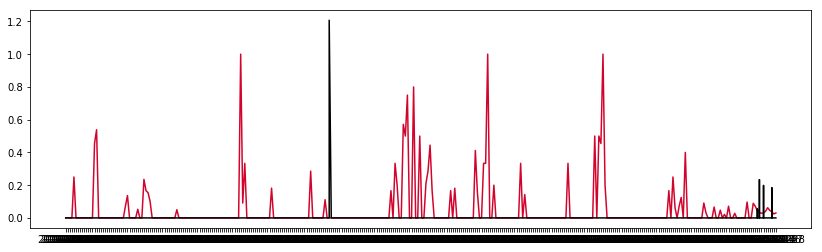

In [490]:
fig, ax = plt.subplots(1, figsize=(14, 4))

ax.plot(y_train_ts1.index, 
        y_train_ts1,
       color ='#D2042D')
ax.plot(y_train_ts1.index, 
        y_hat_ts1,
       color ='black')
;

In [491]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_ts.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

NameError: name 'X_train_series' is not defined

In [492]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()


NameError: name 'LSTM' is not defined

# Appendix

In [73]:
def sample_generator():
    i = 0
    while True:
        i += 1
        yield(i)
        

In [82]:
gen = sample_generator()

In [84]:
next(gen)

2

In [ ]:
def load_data(train_df,idx,
              batch_size):
    df = pd.read_csv(
                  Train_df, skiprows=idx*batch_size,
                  nrows=batch_size)
    x = df.iloc[:,1:]
         
    y = df.iloc[:,0]
    return (np.array(x), np_utils.to_categorical(y))

In [91]:
def load_data(filename, idx):
    df = pd.read_csv('../data/{}{}.csv'.format(filename, idx), index_col=0)
    return df.head(1)

idx = '0'
filename = 'yemen_batch'
load_data(filename, idx)

,Actor1Name,Actor2Name,QuadClass,GoldsteinScale,NumArticles,AvgTone,IsHumanitarianCrisis,sum,count,mean
SQLDATE,,,,,,,,,,
2014-02-19,ADEN,BRITAIN,3,-6.5,3,-2.10325,False,0,9,0.0


In [92]:
def sample_generator(filename):
    idx = 0
    while True:
        yield(load_data(filename, idx))
    

In [93]:
gen = sample_generator(filename)

In [94]:
gen

<generator object sample_generator at 0x7faf0e267bf8>

In [95]:
for x in range(5):
    print(x)
    

0
1
2
3
4


In [135]:
def sam_generator(limit):
    i = 0
    while i<limit:
        i += 1
        yield i




In [136]:
gen = sam_generator(4)

In [141]:
next(gen)

StopIteration: 

In [315]:
def load_data_old(filename, idx):
    df = pd.read_csv('../data/{}{}.csv'.format(filename, idx), index_col=0)
    features = ['Actor1Name','Actor2Name','QuadClass','GoldsteinScale','NumArticles','AvgTone']
    categorical_features = ['Actor1Name','Actor2Name']
    column_trans = make_column_transformer(
                        (OneHotEncoder(handle_unknown = 'ignore'),  categorical_features),
                        remainder='passthrough')
    df.fillna('None', inplace=True)
    X_train = df[features]
    X_train_ohe = column_trans.fit_transform(X_train).toarray()
    y_train = df['mean']
    return X_train_ohe, y_train